In [53]:
import sys, os, time
from statistics import mean
import pandas as pd
import random
from tqdm import tqdm

##############################################################
####                        UTILS                         ####
##############################################################

def cost_of_change(alpha,ring_size,current_cut,next_cut):
    """Computes the cost of change from one cut to another"""
    current_cut = current_cut % (ring_size//2)
    next_cut = next_cut % (ring_size//2)
    if current_cut < next_cut:
        online_cost = 2*alpha*min(next_cut-current_cut, current_cut+(ring_size//2)-next_cut)
    elif current_cut > next_cut:
        online_cost = 2*alpha*min(current_cut-next_cut, next_cut+(ring_size//2)-current_cut)
    else:
        online_cost = 0
    return online_cost
                
def tri_2_arg(list):
    """Prend une liste de couple (a,b) et la trie selon les valeurs de b dans l'ordre croissant"""
    random.shuffle(list)
    return sorted(list, key = lambda x: x[1])

def range_in_ring(x,ring_size,range_size):
    """Retourne la liste des 2*range_size nodes du ring adjacents à x"""
    return [i % (ring_size//2) for i in range(x-range_size,x+range_size+1)] # Ici i % ring_size//2 car i est une coupe
    
def best_cut(alpha,current_cut,ring_size, range_size=2):
    global global_state

    current_cut_range = range_in_ring(current_cut,ring_size,range_size) #range(ring_size//2) for full range
    cost =[[x, 
            global_state['sigma_count'][x]
            +cost_of_change(alpha,ring_size,current_cut,x)] 
           for x in current_cut_range]
    return tri_2_arg(cost)[0][0]

##############################################################
####                   ALGORITHMS                         ####
##############################################################

def online_two_clustering_LAZY(ring_size, alpha, current_cut, current_cost, new_msg, first_call):
    """
        Algorithme lazy qui change la coupe pour donner -1 à chaque fois 
    """
    # utiliser la variable globale
    global global_state 

    # initialiser la variable globale lors du premier appel
    if first_call:
        global_state = {}
        global_state['sigma'] = [new_msg] #liste des messages
        global_state['sigma_count'] = []  #liste telle que l[index] = nombre de fois où le message index ou index+ring_size//2 est lu
        for i in range(ring_size//2):
            global_state['sigma_count'].append(0)
        global_state['sigma_count'][new_msg%(ring_size//2)]
    else:
        global_state['sigma'].append(new_msg)
        global_state['sigma_count'][new_msg%(ring_size//2)]
        
    current_cut = -1        
    return current_cut # la coupe/2-clusters courante est conservée, ceci n'est pas une solution optimale

def online_two_clustering_GREEDY(ring_size, alpha, current_cut, current_cost, new_msg, first_call):
    """
        Algorithme greedy    
    """
    # utiliser la variable globale
    global global_state

    # initialiser la variable globale lors du premier appel
    if first_call:
        global_state = {}
        global_state['sigma'] = [new_msg] #liste des messages
        global_state['sigma_count'] = []  #liste telle que l[index] = nombre de fois où le message index ou index+ring_size//2 est lu
        for i in range(ring_size//2):
            global_state['sigma_count'].append(0)
        global_state['sigma_count'][new_msg%(ring_size//2)] += 1
    else:
        global_state['sigma'].append(new_msg)
        global_state['sigma_count'][new_msg%(ring_size//2)] += 1
    
    if new_msg == current_cut:
        current_cut = best_cut(alpha,current_cut,ring_size, 1) #range de ring_size//4 car on regarde les coupes module ring_size//2  donc ring_size//4 dans chaque sens
    return current_cut

def online_two_clustering_GREEDY_RANDOM(ring_size, alpha, current_cut, current_cost, new_msg, first_call):
    """
        Algorithme greedy with a tiny bit of random   
    """
    # utiliser la variable globale
    global global_state

    # initialiser la variable globale lors du premier appel
    if first_call:
        global_state = {}
        global_state['sigma'] = [new_msg] #liste des messages
        global_state['sigma_count'] = []  #liste telle que l[index] = nombre de fois où le message index ou index+ring_size//2 est lu
        for i in range(ring_size//2):
            global_state['sigma_count'].append(0)
        global_state['sigma_count'][new_msg%(ring_size//2)] += 1
    else:
        global_state['sigma'].append(new_msg)
        global_state['sigma_count'][new_msg%(ring_size//2)] += 1
    
    if new_msg == current_cut:
        current_cut = best_cut(alpha,current_cut,ring_size, 1)
        if random.randint(1,500)==1:
            current_cut = current_cut + 2
    return current_cut 

def online_two_clustering(ring_size, alpha, current_cut, current_cost, new_msg, first_call):
    """
       In use algorithm  
    """
    current_cut = online_two_clustering_GREEDY_RANDOM(ring_size, alpha, current_cut, current_cost, new_msg, first_call)
    return current_cut

##############################################################
#### LISEZ LE README et NE PAS MODIFIER LE CODE SUIVANT ####
##############################################################
if __name__=="__main__":
    input_dir = os.path.abspath('test_dataset')
    output_dir = os.path.abspath('rep_dataset')
    
    # un repertoire des graphes en entree doit être passé en parametre 1
    if not os.path.isdir(input_dir):
        print(input_dir, "doesn't exist")
        exit()
    # un repertoire pour enregistrer les dominants doit être passé en parametre 2
    if not os.path.isdir(output_dir):
        print(output_dir, "doesn't exist")
        exit()       
    
    # fichier des reponses depose dans le output_dir et annote par date/heure
    output_filename = 'answers_{}.txt'.format(time.strftime("%d%b%Y_%H%M%S", time.localtime()))             
    output_file = open(os.path.join(output_dir, output_filename), 'w')
    scores = []
    
    for instance_filename in tqdm(sorted(os.listdir(input_dir))):
        # importer l'instance depuis le fichier (attention code non robuste)
        instance_file = open(os.path.join(input_dir, instance_filename), "r")
        lines = instance_file.readlines()
        
        ring_size = int(lines[1])
        alpha = int(lines[4])
        sigma = [int(d) for d in lines[7].split()]
                
        # lancement de l'algo online 10 fois et calcul du meilleur cout
        nb_runs = 10
        best_cost = float('inf')
        for _ in range(nb_runs):
            online_cost = 0
            current_cut = 0
            first_call = True
            for msg in sigma:
                next_cut = online_two_clustering(ring_size, alpha, current_cut, online_cost, msg, first_call) % (ring_size//2)
                if current_cut < next_cut:
                    online_cost += 2*alpha*min(next_cut-current_cut, current_cut+(ring_size//2)-next_cut)
                if current_cut > next_cut:
                    online_cost += 2*alpha*min(current_cut-next_cut, next_cut+(ring_size//2)-current_cut)
                
                current_cut = next_cut
                if current_cut == msg % (ring_size//2):
                    online_cost += 1
                first_call = False
            best_cost = min(best_cost, online_cost)
        scores.append(best_cost)
        # ajout au rapport
        output_file.write(instance_filename + ': score: {}\n'.format(best_cost))
    output_file.write('score total: ' + str(sum(scores)))
    output_file.close()
    print(sum(scores))

100%|██████████| 15/15 [00:07<00:00,  2.06it/s]

4825


In [130]:
import sys, os, time
from statistics import mean
import pandas as pd
import random
from tqdm import tqdm

# variable globale qui peut servir à stocker des informations d'un appel à l'autre si besoin
global_state = {}
# variable globale p de probabilité 
p = 0.995
#p_values = [0.8, 0.9, 0.995, 0.999, 0.9995, 0.9999]

##############################################################
####                        UTILS                         ####
##############################################################

def cost_of_change(alpha,ring_size,current_cut,next_cut):
    """Computes the cost of change from one cut to another"""
    current_cut = current_cut % (ring_size//2)
    next_cut = next_cut % (ring_size//2)
    if current_cut < next_cut:
        online_cost = 2*alpha*min(next_cut-current_cut, current_cut+(ring_size//2)-next_cut)
    elif current_cut > next_cut:
        online_cost = 2*alpha*min(current_cut-next_cut, next_cut+(ring_size//2)-current_cut)
    else:
        online_cost = 0
    return online_cost
                
def tri_2_arg(list):
    """Prend une liste de couple (a,b) et la trie selon les valeurs de b dans l'ordre croissant"""
    random.shuffle(list)
    return sorted(list, key = lambda x: x[1])

def range_in_ring(x,ring_size,range_size):
    """Retourne la liste des 2*range_size nodes du ring adjacents à x"""
    return [i % (ring_size//2) for i in range(x-range_size,x+range_size+1)] # Ici i % ring_size//2 car i est une coupe
    
def best_cut(alpha,current_cut,ring_size, range_size=2):
    global global_state

    current_cut_range = range_in_ring(current_cut,ring_size,range_size) #range(ring_size//2) for full range
    cost =[[x, 
            global_state['sigma_count'][x]
            +cost_of_change(alpha,ring_size,current_cut,x)] 
           for x in current_cut_range]
    return tri_2_arg(cost)[0][0]

##############################################################
####                   ALGORITHMS                         ####
##############################################################

def online_two_clustering_LAZY(ring_size, alpha, current_cut, current_cost, new_msg, first_call):
    """
        Algorithme lazy qui change la coupe pour donner -1 à chaque fois 
    """
    # utiliser la variable globale
    global global_state 

    # initialiser la variable globale lors du premier appel
    if first_call:
        global_state = {}
        global_state['sigma'] = [new_msg] #liste des messages
        global_state['sigma_count'] = []  #liste telle que l[index] = nombre de fois où le message index ou index+ring_size//2 est lu
        for i in range(ring_size//2):
            global_state['sigma_count'].append(0)
        global_state['sigma_count'][new_msg%(ring_size//2)]
    else:
        global_state['sigma'].append(new_msg)
        global_state['sigma_count'][new_msg%(ring_size//2)]
        
    current_cut = -1        
    return current_cut # la coupe/2-clusters courante est conservée, ceci n'est pas une solution optimale

def online_two_clustering_GREEDY(ring_size, alpha, current_cut, current_cost, new_msg, first_call):
    """
        Algorithme greedy    
    """
    # utiliser la variable globale
    global global_state

    # initialiser la variable globale lors du premier appel
    if first_call:
        global_state = {}
        global_state['sigma'] = [new_msg] #liste des messages
        global_state['sigma_count'] = []  #liste telle que l[index] = nombre de fois où le message index ou index+ring_size//2 est lu
        for i in range(ring_size//2):
            global_state['sigma_count'].append(0)
        global_state['sigma_count'][new_msg%(ring_size//2)] += 1
    else:
        global_state['sigma'].append(new_msg)
        global_state['sigma_count'][new_msg%(ring_size//2)] += 1
    
    if new_msg == current_cut:
        current_cut = best_cut(alpha,current_cut,ring_size, 1) #range de ring_size//4 car on regarde les coupes module ring_size//2  donc ring_size//4 dans chaque sens
    return current_cut

def online_two_clustering_GREEDY_RANDOM(ring_size, alpha, current_cut, current_cost, new_msg, first_call):
    """
        Algorithme greedy with a tiny bit of random   
    """
    # utiliser la variable globale
    global global_state
    global p 

    # initialiser la variable globale lors du premier appel
    if first_call:
        global_state = {}
        global_state['sigma'] = [new_msg] #liste des messages
        global_state['sigma_count'] = []  #liste telle que l[index] = nombre de fois où le message index ou index+ring_size//2 est lu
        for i in range(ring_size//2):
            global_state['sigma_count'].append(0)
        global_state['sigma_count'][new_msg%(ring_size//2)] += 1
    else:
        global_state['sigma'].append(new_msg)
        if random.random()>p:
            global_state['sigma_count'][new_msg%(ring_size//2)] += 1/(1-p)
        else:
            global_state['sigma_count'][new_msg%(ring_size//2)] += 1
    
    if new_msg == current_cut:
        current_cut = best_cut(alpha,current_cut,ring_size, 1)
        
    return current_cut 

def online_two_clustering(ring_size, alpha, current_cut, current_cost, new_msg, first_call):
    """
       In use algorithm  
    """
    current_cut = online_two_clustering_GREEDY(ring_size, alpha, current_cut, current_cost, new_msg, first_call)
    return current_cut

##############################################################
#### LISEZ LE README et NE PAS MODIFIER LE CODE SUIVANT ####
##############################################################
if __name__=="__main__":
    input_dir = os.path.abspath('test_dataset')
    output_dir = os.path.abspath('rep_dataset')
    
    # un repertoire des graphes en entree doit être passé en parametre 1
    if not os.path.isdir(input_dir):
        print(input_dir, "doesn't exist")
        exit()
    # un repertoire pour enregistrer les dominants doit être passé en parametre 2
    if not os.path.isdir(output_dir):
        print(output_dir, "doesn't exist")
        exit()       
    
    # fichier des reponses depose dans le output_dir et annote par date/heure
    output_filename = 'answers_{}.txt'.format(time.strftime("%d%b%Y_%H%M%S", time.localtime()))             
    output_file = open(os.path.join(output_dir, output_filename), 'w')
    scores = []
    
    for instance_filename in tqdm(sorted(os.listdir(input_dir))):
        # importer l'instance depuis le fichier (attention code non robuste)
        instance_file = open(os.path.join(input_dir, instance_filename), "r")
        lines = instance_file.readlines()
        
        ring_size = int(lines[1])
        alpha = int(lines[4])
        sigma = [int(d) for d in lines[7].split()]
                
        # lancement de l'algo online 10 fois et calcul du meilleur cout
        nb_runs = 1
        best_cost = float('inf')
        for _ in range(nb_runs):
            online_cost = 0
            current_cut = 0
            first_call = True
            for msg in sigma:
                next_cut = online_two_clustering(ring_size, alpha, current_cut, online_cost, msg, first_call) % (ring_size//2)
                if current_cut < next_cut:
                    online_cost += 2*alpha*min(next_cut-current_cut, current_cut+(ring_size//2)-next_cut)
                if current_cut > next_cut:
                    online_cost += 2*alpha*min(current_cut-next_cut, next_cut+(ring_size//2)-current_cut)
                
                current_cut = next_cut
                if current_cut == msg % (ring_size//2):
                    online_cost += 1
                first_call = False
            best_cost = min(best_cost, online_cost)
        scores.append(best_cost)
        # ajout au rapport
        output_file.write(instance_filename + ': score: {}\n'.format(best_cost))
    output_file.write('score total: ' + str(sum(scores)))
    output_file.close()
    print(sum(scores))
    #print(scores_table)

100%|██████████| 15/15 [00:01<00:00, 13.62it/s]

4895


In [169]:
import sys, os, time
from statistics import mean
import pandas as pd
import random
import numpy as np
from tqdm import tqdm

# variable globale qui peut servir à stocker des informations d'un appel à l'autre si besoin
global_state = {}
# variable globale p de probabilité 
#p = 0.995
#p_values = [0.8, 0.9, 0.995, 0.999, 0.9995, 0.9999]
p_values = np.linspace(1-1e-2,1-1e-8,50,endpoint=True)

##############################################################
####                        UTILS                         ####
##############################################################

def cost_of_change(alpha,ring_size,current_cut,next_cut):
    """Computes the cost of change from one cut to another"""
    current_cut = current_cut % (ring_size//2)
    next_cut = next_cut % (ring_size//2)
    if current_cut < next_cut:
        online_cost = 2*alpha*min(next_cut-current_cut, current_cut+(ring_size//2)-next_cut)
    elif current_cut > next_cut:
        online_cost = 2*alpha*min(current_cut-next_cut, next_cut+(ring_size//2)-current_cut)
    else:
        online_cost = 0
    return online_cost
                
def tri_2_arg(list):
    """Prend une liste de couple (a,b) et la trie selon les valeurs de b dans l'ordre croissant"""
    random.shuffle(list)
    return sorted(list, key = lambda x: x[1])

def range_in_ring(x,ring_size,range_size):
    """Retourne la liste des 2*range_size nodes du ring adjacents à x"""
    return [i % (ring_size//2) for i in range(x-range_size,x+range_size+1)] # Ici i % ring_size//2 car i est une coupe
    
def best_cut(alpha,current_cut,ring_size, range_size=2):
    global global_state

    current_cut_range = range_in_ring(current_cut,ring_size,range_size) #range(ring_size//2) for full range
    cost =[[x, 
            global_state['sigma_count'][x]
            +cost_of_change(alpha,ring_size,current_cut,x)] 
           for x in current_cut_range]
    return tri_2_arg(cost)[0][0]

##############################################################
####                   ALGORITHMS                         ####
##############################################################

def online_two_clustering_LAZY(ring_size, alpha, current_cut, current_cost, new_msg, first_call):
    """
        Algorithme lazy qui change la coupe pour donner -1 à chaque fois 
    """
    # utiliser la variable globale
    global global_state 

    # initialiser la variable globale lors du premier appel
    if first_call:
        global_state = {}
        global_state['sigma'] = [new_msg] #liste des messages
        global_state['sigma_count'] = []  #liste telle que l[index] = nombre de fois où le message index ou index+ring_size//2 est lu
        for i in range(ring_size//2):
            global_state['sigma_count'].append(0)
        global_state['sigma_count'][new_msg%(ring_size//2)]
    else:
        global_state['sigma'].append(new_msg)
        global_state['sigma_count'][new_msg%(ring_size//2)]
        
    current_cut = -1        
    return current_cut # la coupe/2-clusters courante est conservée, ceci n'est pas une solution optimale

def online_two_clustering_GREEDY(ring_size, alpha, current_cut, current_cost, new_msg, first_call):
    """
        Algorithme greedy    
    """
    # utiliser la variable globale
    global global_state

    # initialiser la variable globale lors du premier appel
    if first_call:
        global_state = {}
        global_state['sigma'] = [new_msg] #liste des messages
        global_state['sigma_count'] = []  #liste telle que l[index] = nombre de fois où le message index ou index+ring_size//2 est lu
        for i in range(ring_size//2):
            global_state['sigma_count'].append(0)
        global_state['sigma_count'][new_msg%(ring_size//2)] += 1
    else:
        global_state['sigma'].append(new_msg)
        global_state['sigma_count'][new_msg%(ring_size//2)] += 1
    
    if new_msg == current_cut:
        current_cut = best_cut(alpha,current_cut,ring_size, 1) #range de ring_size//4 car on regarde les coupes module ring_size//2  donc ring_size//4 dans chaque sens
    return current_cut

def online_two_clustering_GREEDY_RANDOM(ring_size, alpha, current_cut, current_cost, new_msg, first_call):
    """
        Algorithme greedy with a tiny bit of random   
    """
    # utiliser la variable globale
    global global_state
    global p 
    
    # initialiser la variable globale lors du premier appel
    if first_call:
        global_state = {}
        global_state['sigma'] = [new_msg] #liste des messages
        global_state['sigma_count'] = []  #liste telle que l[index] = nombre de fois où le message index ou index+ring_size//2 est lu
        for i in range(ring_size//2):
            global_state['sigma_count'].append(0)
        global_state['sigma_count'][new_msg%(ring_size//2)] += 1
    else:
        global_state['sigma'].append(new_msg)
        if random.random()>p:
            global_state['sigma_count'][new_msg%(ring_size//2)] += 1/(1-p)
        else:
            global_state['sigma_count'][new_msg%(ring_size//2)] += 1
    
    if new_msg == current_cut:
        current_cut = best_cut(alpha,current_cut,ring_size, 1)
        
    return current_cut 

def online_two_clustering(ring_size, alpha, current_cut, current_cost, new_msg, first_call):
    """
       In use algorithm  
    """
    current_cut = online_two_clustering_GREEDY_RANDOM(ring_size, alpha, current_cut, current_cost, new_msg, first_call)
    return current_cut

##############################################################
#### LISEZ LE README et NE PAS MODIFIER LE CODE SUIVANT ####
##############################################################
if __name__=="__main__":
    input_dir = os.path.abspath('test_dataset')
    output_dir = os.path.abspath('rep_dataset')
    
    # un repertoire des graphes en entree doit être passé en parametre 1
    if not os.path.isdir(input_dir):
        print(input_dir, "doesn't exist")
        exit()
    # un repertoire pour enregistrer les dominants doit être passé en parametre 2
    if not os.path.isdir(output_dir):
        print(output_dir, "doesn't exist")
        exit()       
    
    # fichier des reponses depose dans le output_dir et annote par date/heure
    output_filename = 'answers_{}.txt'.format(time.strftime("%d%b%Y_%H%M%S", time.localtime()))             
    output_file = open(os.path.join(output_dir, output_filename), 'w')
    scores = []
    scores_table = {}
    
    for p in p_values:
        scores_table[p] = []
        for instance_filename in tqdm(sorted(os.listdir(input_dir))):
            # importer l'instance depuis le fichier (attention code non robuste)
            instance_file = open(os.path.join(input_dir, instance_filename), "r")
            lines = instance_file.readlines()

            ring_size = int(lines[1])
            alpha = int(lines[4])
            sigma = [int(d) for d in lines[7].split()]

            # lancement de l'algo online 10 fois et calcul du meilleur cout
            nb_runs = 10
            best_cost = float('inf')
            best_cost = []
            for _ in range(nb_runs):
                online_cost = 0
                current_cut = 0
                first_call = True
                for msg in sigma:
                    next_cut = online_two_clustering(ring_size, alpha, current_cut, online_cost, msg, first_call) % (ring_size//2)
                    if current_cut < next_cut:
                        online_cost += 2*alpha*min(next_cut-current_cut, current_cut+(ring_size//2)-next_cut)
                    if current_cut > next_cut:
                        online_cost += 2*alpha*min(current_cut-next_cut, next_cut+(ring_size//2)-current_cut)

                    current_cut = next_cut
                    if current_cut == msg % (ring_size//2):
                        online_cost += 1
                    first_call = False
                    #best_cost = min(best_cost, online_cost)
                best_cost += [online_cost]
            scores_table[p] += [best_cost]
            scores.append(mean(best_cost))
        # ajout au rapport
        output_file.write(instance_filename + ': score: {}\n'.format(best_cost))
    output_file.write('score total: ' + str(sum(scores)))
    output_file.close()
    #print(sum(scores))
    #print(scores_table)

100%|██████████| 15/15 [00:08<00:00,  1.75it/s]


In [170]:
finale_scores = {}
for p in scores_table.keys():
    score = pd.DataFrame(scores_table[p]).T
    score['sum'] = score.sum(axis=1)
    score_moyen = mean(score['sum'])
    
    score = pd.DataFrame(scores_table[p])
    score['min'] = score.min(axis=1)
    score_min = score['min'].sum()
    
    finale_scores[p] = (score_moyen,score_min)
        
finale_scores

{0.99: (5040.2, 4786),
 0.9902040814285714: (5044.2, 4830),
 0.9904081628571428: (5079.4, 4846),
 0.9906122442857143: (5122.4, 4852),
 0.9908163257142857: (5077.6, 4819),
 0.9910204071428571: (5052.4, 4831),
 0.9912244885714285: (5036, 4790),
 0.99142857: (5103, 4814),
 0.9916326514285714: (5062.8, 4798),
 0.9918367328571428: (5099.4, 4819),
 0.9920408142857142: (5078.7, 4807),
 0.9922448957142856: (5091.7, 4812),
 0.9924489771428571: (5008.1, 4786),
 0.9926530585714286: (5035.7, 4786),
 0.99285714: (5031.7, 4793),
 0.9930612214285715: (5086.5, 4783),
 0.9932653028571429: (5014.5, 4822),
 0.9934693842857143: (5042.8, 4850),
 0.9936734657142857: (5018.8, 4819),
 0.9938775471428571: (5045.5, 4835),
 0.9940816285714286: (5098.1, 4815),
 0.99428571: (5060.8, 4829),
 0.9944897914285714: (4988.7, 4750),
 0.9946938728571428: (5058.7, 4763),
 0.9948979542857143: (4998.5, 4797),
 0.9951020357142857: (5010.1, 4838),
 0.9953061171428571: (5050.8, 4780),
 0.9955101985714285: (5045.3, 4834),
 0.995

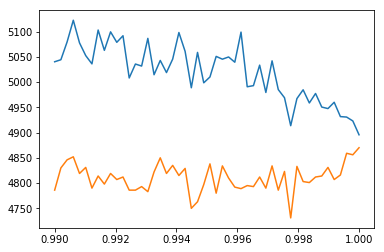

In [171]:
import matplotlib.pyplot as plt

Y1 = []
Y2 = []
for p in scores_table.keys():
    Y1 += [finale_scores[p][0]]
    Y2 += [finale_scores[p][1]]
    
plt.plot(finale_scores.keys(), Y1);
plt.plot(finale_scores.keys(), Y2)